In [5]:
library(rugarch)
library(VineCopula)
library(fGarch) 
library(quantreg)
library(readxl)
library(xts)

Warning message:
"package 'rugarch' was built under R version 4.2.3"


Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


Warning message:
"package 'VineCopula' was built under R version 4.2.3"
Warning message:
"package 'fGarch' was built under R version 4.2.3"
NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")

Warning message:
"package 'quantreg' was built under R version 4.2.3"
Loading required package: SparseM


Attaching package: 'SparseM'


The following object is masked from 'package:base':

    backsolve


Warning message:
"package 'readxl' was built under R version 4.2.3"
Warning message:
"package 'xts' was built under R version 4.2.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.2.3"

Attaching package: 'zoo'


The following objects are masked from 'package:b

In [6]:
#用相对路径读取数据更整洁，代码鲁棒性更强
df <- read_excel("./test.xlsx")
df$日期 <- as.Date(df$日期, format = "%Y-%m-%d")
# 调整为日期格式
ts_df <- xts(df[-1], order.by = df$日期)
date_st <- index(ts_df)
dim(ts_df)
tail(ts_df)

[1] 1678   39

           香蜜湖指数   中国银行   工商银行   交通银行   建设银行   中信银行
2024-04-16 -4.0291639  1.0834342  0.9182801  0.2989539  0.4192878 -1.5015297
2024-04-17  4.2765524  0.4301082  0.5469476  0.8915364  1.5225208  9.5172638
2024-04-18 -0.3160644  0.6417134  0.3629768  1.3225762  0.2743486  8.6896744
2024-04-19 -1.6792034  0.6376217  0.5420067  0.7272759  0.6825965 -8.6896744
2024-04-22  0.3443545 -1.2793351 -1.2692827 -0.8733680 -0.6825965 -3.4993074
2024-04-23  0.5518959  0.0000000  0.3642991  1.1628038  0.1368926  0.2844952
              平安银行   浦发银行    招商银行   华夏银行    中信证券   海通证券
2024-04-16 -0.09722898 -0.5494519 -0.24397694 -0.3007521 -0.62199805 -1.6571444
2024-04-17  3.25387558  1.0959014  1.66544349  1.9389123  2.63099419  1.9096697
2024-04-18  1.68071183 -0.1363327  1.04556591  0.8823587  0.60589555  1.6260521
2024-04-19 -1.02374091  0.1363327 -0.08919281  0.2923979 -0.44028690 -0.2484473
2024-04-22 -1.79334679 -0.6835297 -0.83632507 -0.5856532  0.82395413  0.6199648
2024-04-23  0.38022859  0.6835

In [7]:
#ARMA egarch model
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH"), 
distribution.model = "sstd")
#用刚刚定义的模型拟合各列数据
f1 <- function(x) {ugarchfit(uspec, data = x)}
fit <- apply(ts_df,2, f1)

In [8]:
# 保存ugarchfit对象，这样就不用重复跑了
saveRDS(fit, file = "garch_model.rds")
#读取模型
fit <- readRDS(file = "garch_model.rds")

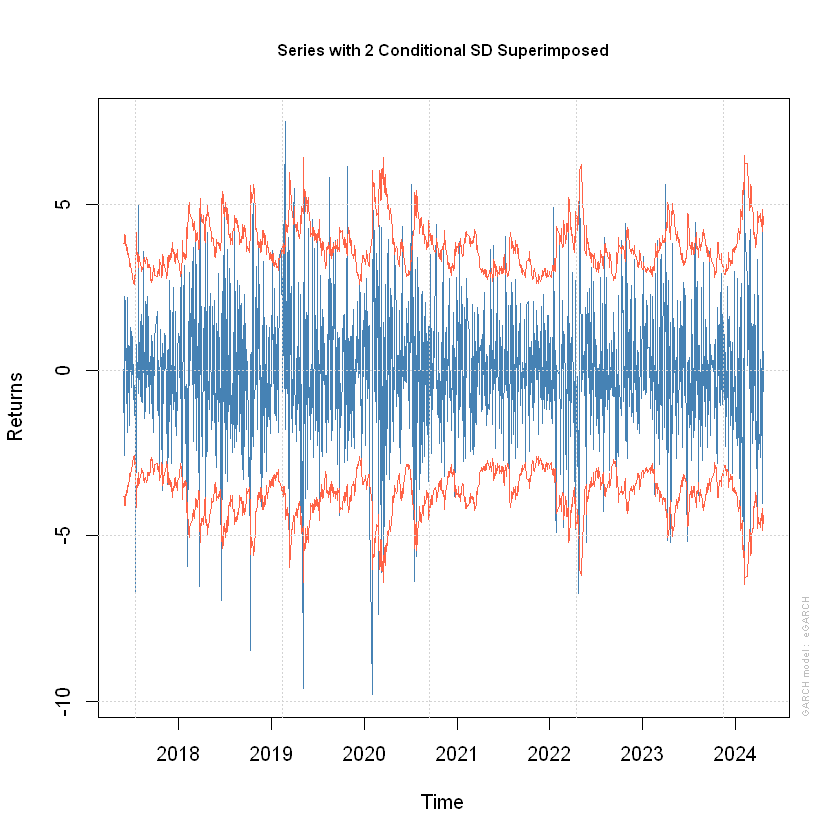

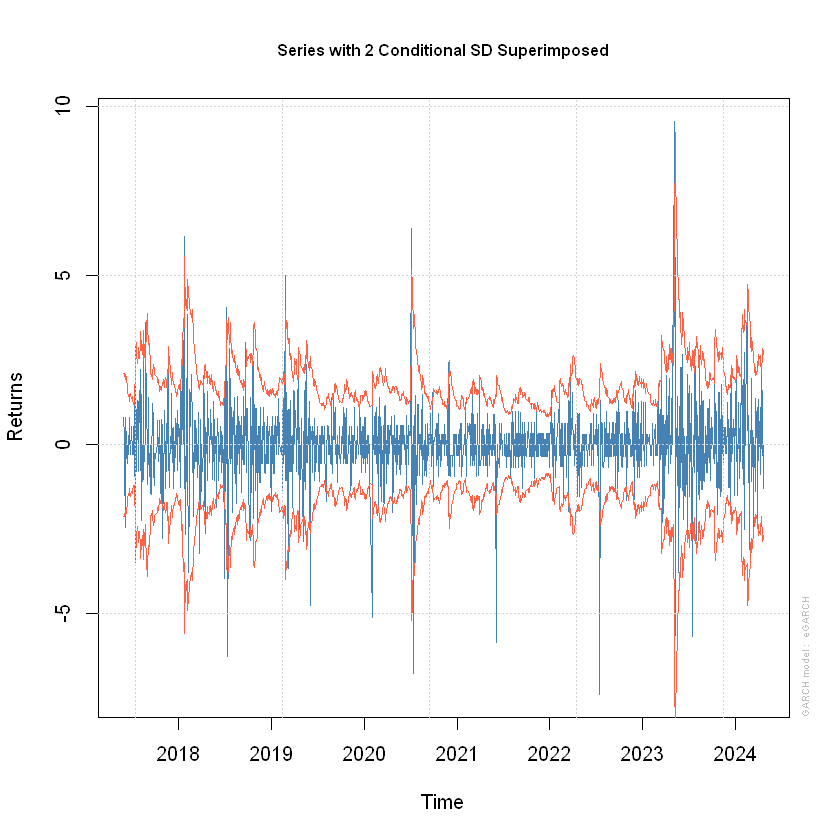

In [9]:
#绘图（先以香蜜湖指数和中国银行为例）
plot(fit$香蜜湖指数,which=1)
plot(fit$中国银行,which=1)

In [10]:
fintech_res <- residuals(fit$香蜜湖指数)
index(fintech_res) <- date_st
cbank_res <- residuals(fit$中国银行)
index(cbank_res) <- date_st

In [11]:
##process of Returns of the 中国银行
## <-记得加空格，代码规范
spec_cbank <- uspec
setfixed(spec_cbank) <- as.list(coef(fit$中国银行))

filt_cbank <- ugarchfilter(spec_cbank, ts_df$中国银行)

In [12]:
length(cbank_res) == length(sigma(filt_cbank))

[1] TRUE

In [13]:
rrss <- cbind(cbank_res,sigma(filt_cbank),cbank_res/sigma(filt_cbank))
ssss1 <- cbind(ts_df$中国银行, fitted(filt_cbank), cbank_res, sigma(filt_cbank), cbank_res/sigma(filt_cbank))
rrss

              cbank_res sigma.filt_cbank. cbank_res.sigma.filt_cbank.
2017-05-31  0.781207516         1.0622322                 0.735439511
2017-06-01  0.296540028         1.0622322                 0.279166865
2017-06-02 -0.517334369         1.0273611                -0.503556494
2017-06-05 -2.483256917         0.9781536                -2.538718822
2017-06-06  0.080472196         1.0376215                 0.077554482
2017-06-07  0.728605696         0.9734949                 0.748443286
2017-06-08 -0.029844984         1.0149074                -0.029406606
2017-06-09 -0.322765216         0.9429306                -0.342300079
2017-06-12 -0.615227546         0.8925022                -0.689328875
2017-06-13 -0.094365971         0.8616881                -0.109512906
       ...                                                           
2024-04-10  0.199921669         1.2532324                 0.159524822
2024-04-11 -0.434071797         1.1840387                -0.366602710
2024-04-12  0.191142

In [14]:
##process of Returns of the 香蜜湖指数
spec_fintech <- uspec
setfixed(spec_fintech)<-as.list(coef(fit$香蜜湖指数))
filt_fintech <- ugarchfilter(spec_fintech, ts_df$香蜜湖指数)
rrss1 <- cbind(fintech_res,sigma(filt_fintech),fintech_res/sigma(filt_fintech))
ssss2 <- cbind(ts_df$香蜜湖指数,fitted(filt_fintech),fintech_res,sigma(filt_fintech),fintech_res/sigma(filt_fintech))

aaaa <- cbind(fintech_res/sigma(filt_fintech),cbank_res/sigma(filt_cbank))

In [15]:
write.csv(aaaa, "E:\\硕士毕业论文\\Rcode\\cbank_residuals.csv")
ts_df_1 <- read.csv('E:\\硕士毕业论文\\Rcode\\cbank_residuals.csv')

In [16]:
##input the redusuals of returns
dim(ts_df_1)
tail(ts_df_1)
tail(aaaa)

[1] 1678    3

,X,fintech_res.sigma.filt_fintech.,cbank_res.sigma.filt_cbank.
,<int>,<dbl>,<dbl>
1673,1673,-1.88005276,0.905572943
1674,1674,1.78924427,0.397092784
1675,1675,-0.04012605,0.541572495
1676,1676,-0.80141927,0.547213474
1677,1677,0.17766124,-0.825137488
1678,1678,0.27698175,-0.001350899


           fintech_res.sigma.filt_fintech. cbank_res.sigma.filt_cbank.
2024-04-16                     -1.88005276                 0.905572943
2024-04-17                      1.78924427                 0.397092784
2024-04-18                     -0.04012605                 0.541572495
2024-04-19                     -0.80141927                 0.547213474
2024-04-22                      0.17766124                -0.825137488
2024-04-23                      0.27698175                -0.001350899

In [17]:
# 检查数据框的列名
print(names(ts_df_1))


[1] "X"                               "fintech_res.sigma.filt_fintech."
[3] "cbank_res.sigma.filt_cbank."    


In [18]:
o <- order(ts_df_1$fintech_res.sigma.filt_fintech.)
rd <- cbind(ts_df_1$fintech_res.sigma.filt_fintech.[o], ts_df_1$cbank_res.sigma.filt_cbank.[o])
x <- rd[, 1]
y <- rd[, 2]

In [19]:
xml <- x
cbank <- y
est.xml <- as.numeric(sstdFit(xml)$estimate)
est.cbank <- as.numeric(sstdFit(cbank)$estimate)


Warning message in sqrt(nu - 2):
"NaNs produced"
Warning message in beta(1/2, nu/2):
"NaNs produced"
Warning message in nlm(f = loglik, p = p, y = x, ...):
"NA/Inf replaced by maximum positive value"
Warning message in log(dsstd(y, x[1], x[2], x[3], x[4])):
"NaNs produced"
Warning message in nlm(f = loglik, p = p, y = x, ...):
"NA/Inf replaced by maximum positive value"


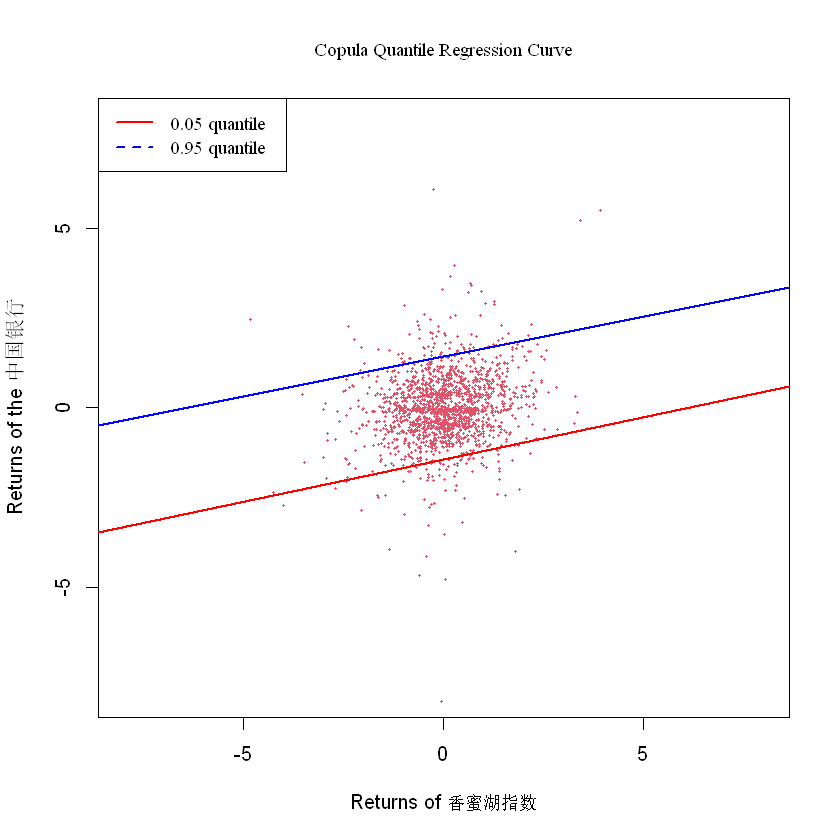

In [20]:

rq05 <- rq(y ~ x, tau = 0.05, data = Dat)  # 0.05分位数回归
rq95 <- rq(y ~ x, tau = 0.95, data = Dat)  # 0.95分位数回归
# 绘制基础图形
plot(x, y, col = 2, cex = 0.5, pch = 20, xlim = c(-8, 8), ylim = c(-8, 8),
     main = 'Copula Quantile Regression Curve', font.main = 6, cex.main = 0.95,
     xlab = 'Returns of 香蜜湖指数', ylab = 'Returns of the 中国银行')

# 添加分位数回归线
abline(rq05, col = "red", lwd = 2)  # 0.05分位数线
abline(rq95, col = "blue", lwd = 2)  # 0.95分位数线

# 添加图例
legend('topleft', c("0.05 quantile", "0.95 quantile"), col = c("red", "blue"),   
       lty = c(1, 2), lwd = c(2, 2), cex = 0.95, text.font = 6)


In [21]:
Dat <- NULL
Dat$x <- x
Dat$y <- y


In [23]:
#Rotated Gumbel copula quantile regression model
u <- psstd(x, mean = est.xml[1], sd = est.xml[2], nu = est.xml[3], xi = est.xml[4])


189.1114 :   1.1257506 -0.1261274  1.0103893 
final  value 188.028455 
converged
lambda = 0.1165818 
188.0285 :  1.11836771 0.04075431 1.02330581 
final  value 187.497354 
stopped after 7 iterations
lambda = 0.2926788 
187.4974 :  1.0561643 0.5298726 1.3096458 
final  value 187.497354 
converged
lambda = 0 
187.4974 :  1.0561643 0.5298726 1.3096458 



Call: nlrq(formula = y ~ GumbelModel(x, delta, mu, sigma, tau), data = Dat, 
    start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.05

Coefficients:
      Value   Std. Error t value Pr(>|t|)
delta 1.05616 0.13360    7.90570 0.00000 
mu    0.52987 3.31965    0.15962 0.87320 
sigma 1.30965 2.22708    0.58806 0.55657 

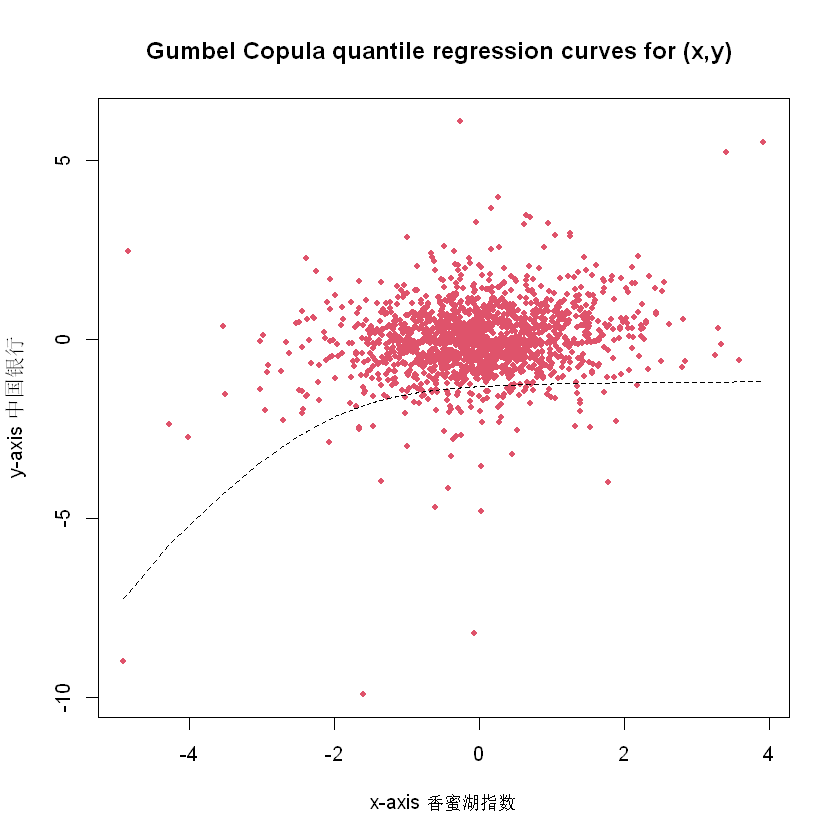

In [29]:
# 初始化deltas矩阵
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 适当调整行数和列数
}

GumbelModel <- function(x, alpha, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- psstd(x,mean=est.xml[1], sd=est.xml[2],nu=est.xml[3], xi=est.xml[4])
for(i in 1 :length(u))
{
rootf1 <- function(v){1 - exp(-((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^(1/alpha)) * 
    (((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^((1/alpha) - 
        1) * ((1/alpha) * ((-log(1 - u[i]))^(alpha - 1) * (alpha * 
        (1/(1 - u[i]))))))-tau}
vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
v[i,1] <- vx$root
}
z <- qsstd(v, mean=est.cbank[1], sd=est.cbank[2], nu=est.cbank[3], xi=est.cbank[4])
mu + sigma * z
}
##mu is the panning parameter and sigma is the zooming parameter 
tau = 0.05
fit3 <- nlrq(y ~ GumbelModel(x, delta,mu, sigma, tau),
data=Dat, tau=tau, start = list(delta=1.1257506, mu=-0.1261274, sigma=1.0103893), trace=TRUE)
plot(x, y, main="Rotated Gumbel Copula quantile regression curves for (x,y) ", xlab="x-axis 香蜜湖指数", ylab="y-axis 中国银行", type='p',col = 2, pch=20)
lines(x, predict(fit3, newdata = x), lty = 2, lwd = 1, col = 1)
deltas[3,] <- coef(fit3)
summary(fit3)


182.4029 :  1.2157506 0.1861274 1.0158930 
final  value 180.573283 
stopped after 5 iterations
lambda = 0.1115145 
180.5733 :  1.20452346 0.07494357 0.97484275 
final  value 180.436813 
stopped after 5 iterations
lambda = 0.221296 
180.4368 :   1.1481099 -0.1568354  1.0442682 
final  value 178.909228 
converged
lambda = 0.410478 
178.9092 :   1.0668778 -0.5095499  1.2583087 
final  value 178.908960 
converged
lambda = 0.0001223509 
178.909 :   1.0668673 -0.5097593  1.2584501 
final  value 178.908960 
converged
lambda = 0 
178.909 :   1.0668673 -0.5097593  1.2584501 



Call: nlrq(formula = y ~ uGumbelModel(x, delta, mu, sigma, tau), data = Dat, 
    start = list(delta = 1.2157506, mu = 0.1861274, sigma = 1.015893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.95

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.06687  0.19383    5.50418  0.00000
mu    -0.50976  4.15878   -0.12257  0.90246
sigma  1.25845  2.71128    0.46415  0.64260

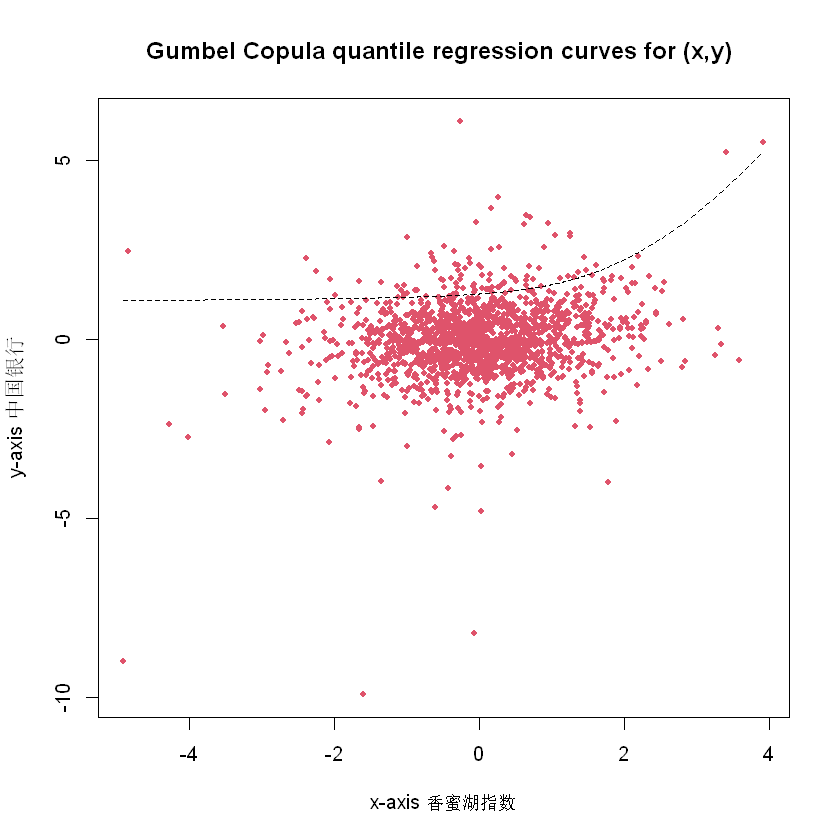

In [33]:
#Gumbel copula quantile regression model
u <- psstd(x, mean=est.xml[1], sd=est.xml[2], nu=est.xml[3], xi=est.xml[4])
uGumbelModel <- function(x, delta, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- psstd(x, mean=est.xml[1], sd=est.xml[2], nu=est.xml[3], xi=est.xml[4])
for(i in 1 :length(u))
{
rootf1 <- function(v){exp(-((-log(u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u[i]))^(delta - 1) * (delta * (1/u[i])))))-tau}
vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
v[i,1] <- vx$root
}
z <- qsstd(v, mean=est.cbank[1], sd=est.cbank[2], nu=est.cbank[3], xi=est.cbank[4])
mu + sigma * z
}

tau=0.95
fit1 <- nlrq(y ~ uGumbelModel(x, delta, mu, sigma, tau),
data=Dat, tau=tau, start=list(delta=1.2157506, mu=0.1861274, sigma=1.015893), trace=TRUE)
plot(x, y, main="Gumbel Copula quantile regression curves for (x,y) ", xlab="x-axis 香蜜湖指数", ylab="y-axis 中国银行", type='p',col = 2, pch=20)
lines(x, predict(fit1, newdata=x), lty=2, lwd=1, col=1)
deltas[3,] <- coef(fit1)
summary(fit1)


In [35]:
#########################estimate the CoVaR######tau=0.05
tau <- 0.05

u_u <- c(0.5, 0.1, 0.05, 0.01)

delta <- coef(fit3)[1]
mu <- coef(fit3)[2]
sigma <- coef(fit3)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1<-function(v){1 - exp(-((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^(1/delta)) * 
    (((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^((1/delta) -
        1) * ((1/delta) * ((-log(1 - u_u[i]))^(delta - 1) * (delta *
        (1/(1 - u_u[i]))))))-tau}
vx<-uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- qsstd(v_x[i], mean=est.cbank[1], sd=est.cbank[2], nu=est.cbank[3], xi=est.cbank[4])
}

z_u <- v_f

f_hat_u <- mu+sigma*z_u


In [37]:
###downside CoVaR
CoVaR_005_050 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[1]
CoVaR_005_010 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[2]
delta_CoVaR_005_010<-CoVaR_005_010-CoVaR_005_050

CoVaR_005_005 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[3]
delta_CoVaR_005_005<-CoVaR_005_005-CoVaR_005_050

CoVaR_005_001 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[4]
delta_CoVaR_005_001<-CoVaR_005_001-CoVaR_005_050

##  2  tau=0.95
tau <- 0.95

u_u <- c(0.5, 0.9, 0.95, 0.99)

delta <- coef(fit1)[1]
mu <- coef(fit1)[2]
sigma <- coef(fit1)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1 <- function(v){
exp(-((-log(u_u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u_u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u_u[i]))^(delta - 1) * (delta * (1/u_u[i])))))-tau
}
vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- qsstd(v_x[i],mean=est.cbank[1],sd=est.cbank[2],nu=est.cbank[3],xi=est.cbank[4])
}

z_u <- v_f 

f_hat_u <- mu+sigma*z_u


In [39]:
###upside CoVaR
CoVaR_095_050 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[1]
CoVaR_095_010 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[2]
delta_CoVaR_095_010<-CoVaR_095_010-CoVaR_095_050

CoVaR_095_005 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[3]
delta_CoVaR_095_005<-CoVaR_095_005-CoVaR_095_050

CoVaR_095_001 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[4]
delta_CoVaR_095_001 <- CoVaR_095_001-CoVaR_095_050


           CoVaR_005_050 CoVaR_005_005 delta_CoVaR_005_005 CoVaR_095_050
2017-05-31     -1.361921     -1.914026          -0.5521048      1.388273
2017-06-01     -1.417057     -1.969162          -0.5521048      1.333137
2017-06-02     -1.361541     -1.895522          -0.5339803      1.298369
2017-06-05     -1.244216     -1.752620          -0.5084042      1.288293
2017-06-06     -1.161460     -1.700773          -0.5393132      1.525016
2017-06-07     -1.180090     -1.686073          -0.5059828      1.340357
           CoVaR_095_005 delta_CoVaR_095_005
2017-05-31      2.046550           0.6582769
2017-06-01      1.991414           0.6582769
2017-06-02      1.935036           0.6366669
2017-06-05      1.894465           0.6061725
2017-06-06      2.168041           0.6430254
2017-06-07      1.943642           0.6032854

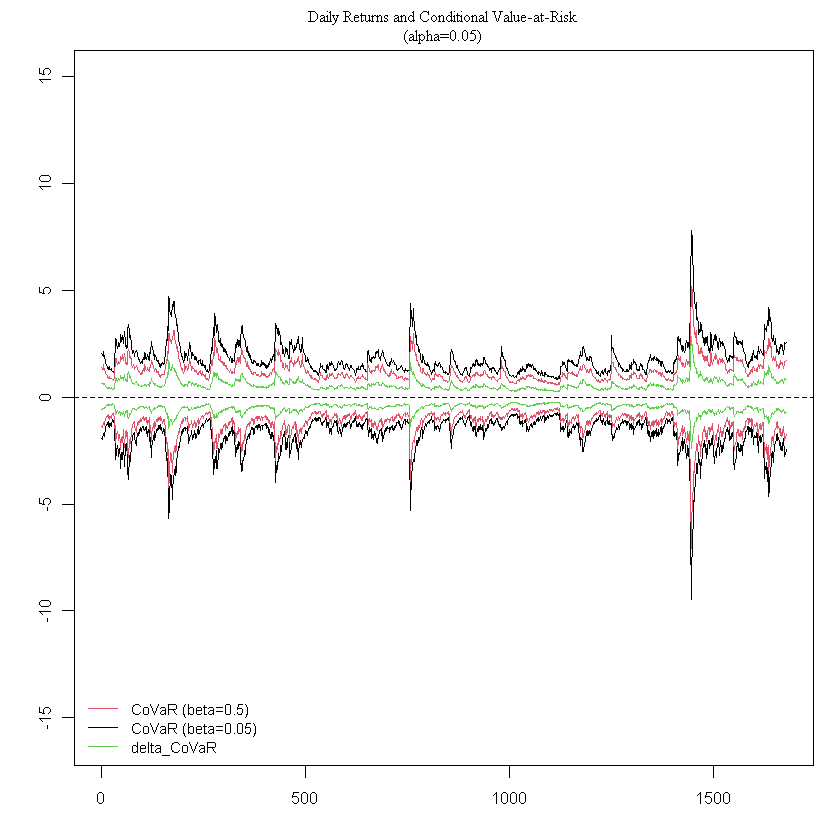

In [42]:
##plot the dynamic CoVaR and delta CoVaR
op <- par(mfrow=c(1,1), mgp=c(1.5, 0.8,0), mar= .1+c(3,3,2,1),
font.main=6, font.lab=6)
n <- length(ts_df_1$cbank)
tt <- seq(1:length(ts_df_1$cbank))
plot(tt,ts_df$cbank, type = "n", main =paste('Daily Returns and Conditional Value-at-Risk\n',
    "(alpha=", 0.05, ")", sep = ""), ylab = '', xlab = '', xlim=c(1,n),
            ylim = c(-16, 15), 
           cex.main = 0.8,  cex.lab = 0.9, cex.axis = 0.8)
        points(ts_df$cbank, pch = 19, col = 'gray', cex=0.5)
        abline(h = 0, col = "1", lty = 2)
lines(tt,CoVaR_005_005, lwd = 1, col = 1)
lines(tt,CoVaR_005_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_005_005, lwd = 1, col = 3,lty=1)
lines(tt,CoVaR_095_005, lwd = 1, col = 1)
lines(tt,CoVaR_095_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_095_005, lwd = 1, col = 3,lty=1)

legend("bottomleft", c("CoVaR (beta=0.5)", "CoVaR (beta=0.05)", 
            "delta_CoVaR"), col = c("2", "1", "3"), cex = 0.75, 
          lty = c(1, 1, 1), lwd = c(1, 1, 1), bty = "n")

dynamic <- cbind(CoVaR_005_050,CoVaR_005_005,delta_CoVaR_005_005,
CoVaR_095_050, CoVaR_095_005,delta_CoVaR_095_005,
ts_df$cbank)

head(dynamic)


In [44]:
write.csv(dynamic, "E:\\硕士毕业论文\\base_CoVaR\\cbank.csv")